<a id='sec0'></a>
# Outputting a file for 1st submission
1. <a href='#sec1'>Import Modules and Data</a><br>
<br>
2. <a href='#sec2'>Digitize both train and test sets</a><br>
<br>
3. <a href='#sec3'>Create subset of feature spaces</a>
    - Use features from F001 univariate selection<br>
<br>
4. <a href='#sec4'>Resample train set</a>
    - Tomek Link majority
    - Undersample majority, oversample minority<br>
<br>  
5. <a href='#sec5'>Train XGBoost, make a prediction, save result</a><br>

<a id='sec1'></a>
# Import Modules and Data
(<a href='#sec0'>back to top</a>)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from xgboost import XGBClassifier

%matplotlib inline

In [3]:
from feature_processing import (create_contingency_table,
                                calculate_conditional_prob_bin,
                                encode_my_categorical_labels,
                                calculate_conditional_prob_cat,
                                estimate_cond_prob_density,
                                bin_myFeature)

In [4]:
train_ori = pd.read_csv('train.csv', header=0)
test_ori = pd.read_csv('test.csv', header=0)
train = pd.read_csv('./data/train_probas.csv', header=0)
test = pd.read_csv('./data/test_probas.csv', header=0)

In [5]:
print('Train Set Shape: ', train.shape)
print(' Test Set Shape: ', test.shape)

Train Set Shape:  (595212, 31)
 Test Set Shape:  (892816, 31)


In [6]:
num_samples = len(train_ori.target)
num_target = np.sum(train_ori.target)
freq_target = num_target/num_samples
freq_target

0.036447517859182946

In [7]:
test.columns

Index(['ps_calc_01_proba', 'ps_calc_02_proba', 'ps_calc_03_proba',
       'ps_calc_04_proba', 'ps_calc_05_proba', 'ps_calc_06_proba',
       'ps_calc_07_proba', 'ps_calc_08_proba', 'ps_calc_09_proba',
       'ps_calc_10_proba', 'ps_calc_11_proba', 'ps_calc_12_proba',
       'ps_calc_13_proba', 'ps_calc_14_proba', 'ps_car_11_proba',
       'ps_car_12_proba', 'ps_car_13_proba', 'ps_car_14_proba',
       'ps_car_15_proba', 'ps_ind_01_proba', 'ps_ind_03_proba',
       'ps_ind_14_proba', 'ps_ind_15_proba', 'ps_reg_01_proba',
       'ps_reg_02_proba', 'ps_reg_03_proba', 'ind_bin_proba', 'calc_bin_proba',
       'car_cat_proba1', 'car_cat_proba2', 'ind_cat_proba'],
      dtype='object')

In [8]:
test.iloc[:, -5:] = test.iloc[:, -5:].replace({np.NaN: freq_target})

<a id='sec4'></a>
# Resample Train Set
(<a href='#sec0'>back to top</a>)

In [9]:
X = np.array(train)
y = np.array(train_ori['target'])

print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (595212, 31)
y shape:  (595212,)


In [10]:
pca = PCA()
Xpca = pca.fit_transform(X)

In [11]:
%%time
# Tomek Links to denoise majority
if True:
    tl = TomekLinks(n_jobs=8, ratio='majority')
    X_tl, y_tl = tl.fit_sample(Xpca, y)

    print('Before tomek links: size of X: ', X.shape)
    print('After  tomek links: size of X: ', X_tl.shape)
    print('Before tomek links: class0/class1 = %d / %d' % (len(y)-np.sum(y), np.sum(y)))
    print('After  tomek links: class0/class1 = %d / %d' % (len(y_tl)-np.sum(y_tl), np.sum(y_tl)))

Before tomek links: size of X:  (595212, 31)
After  tomek links: size of X:  (586790, 31)
Before tomek links: class0/class1 = 573518 / 21694
After  tomek links: class0/class1 = 565096 / 21694
CPU times: user 55min 50s, sys: 257 ms, total: 55min 50s
Wall time: 7min 9s


In [12]:
# Set targets for the number of each class
# Here, set class0:class1 = 1:1
num_class1 = np.sum(y_tl)
num_class1_to_resample = 2 * num_class1
num_class0_to_resample = int(1 * num_class1_to_resample)

# First, randomly undersample the majority
rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
X_tlrus, y_tlrus = rus.fit_sample(X_tl, y_tl)

# Then use SMOTE to oversample the minority
smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=4)
X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

In [13]:
# Print Resampling Results
print('Before Resampling: size of X: ', X_tl.shape)
print('After  Resampling: size of X: ', X_res.shape)
print('Before Resampling: class0/class1 =%7d/%6d' % (len(y_tl)-np.sum(y_tl), np.sum(y_tl)))
print('After  Resampling: class0/class1 =%7d/%6d' % (len(y_res)-np.sum(y_res), np.sum(y_res)))

Before Resampling: size of X:  (586790, 31)
After  Resampling: size of X:  (86776, 31)
Before Resampling: class0/class1 = 565096/ 21694
After  Resampling: class0/class1 =  43388/ 43388


<a id='sec5'></a>
# Train XGBoost, predict probabilities, save to a file
(<a href='#sec0'>back to top</a>)

In [14]:
if True:
# Train XGBoost
    clf = XGBClassifier(gamma=9, subsample=0.85, max_depth=11, 
                        min_child_weight=4, learning_rate=0.05, 
                        n_estimators=200, n_jobs=8)

    clf.fit(X_res, y_res)

In [15]:
if False:
    clf = RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=8)
    clf.fit(X_res, y_res)

In [16]:
X_test = np.array(test)
y_ids = np.array(test_ori.id)

In [17]:
Xpca_test = pca.transform(X_test)

In [18]:
X_test.shape, y_ids.shape

((892816, 31), (892816,))

In [19]:
y_probas = clf.predict_proba(Xpca_test)

In [20]:
y_probas.shape

(892816, 2)

In [21]:
prediction_result = pd.DataFrame({'id': y_ids, 'target': y_probas[:, 1]})
prediction_result = prediction_result[['id', 'target']]

In [22]:
prediction_result.head(10)

,id,target
0,0,0.253170
1,1,0.305863
2,2,0.244233
3,3,0.133428
4,4,0.336523
5,5,0.465561
6,6,0.184210
7,8,0.278179
8,10,0.420010
9,11,0.461205


In [23]:
#prediction_result.to_csv('./submissions/porto_seguro_submission_RH8.csv', index=False, header=True)

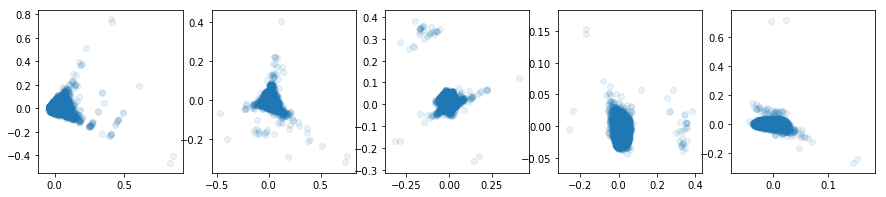

In [24]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 3))
ax1.scatter(Xpca_test[:200000, 0], Xpca_test[:200000, 1], alpha=0.1)
ax2.scatter(Xpca_test[:200000, 1], Xpca_test[:200000, 2], alpha=0.1)
ax3.scatter(Xpca_test[:200000, 2], Xpca_test[:200000, 3], alpha=0.1)
ax4.scatter(Xpca_test[:200000, 3], Xpca_test[:200000, 4], alpha=0.1)
ax5.scatter(Xpca_test[:200000, 4], Xpca_test[:200000, 5], alpha=0.1)

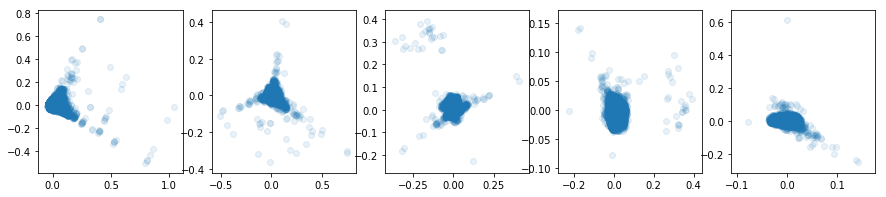

In [25]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 3))
ax1.scatter(Xpca[:200000, 0], Xpca[:200000, 1], alpha=0.1)
ax2.scatter(Xpca[:200000, 1], Xpca[:200000, 2], alpha=0.1)
ax3.scatter(Xpca[:200000, 2], Xpca[:200000, 3], alpha=0.1)
ax4.scatter(Xpca[:200000, 3], Xpca[:200000, 4], alpha=0.1)
ax5.scatter(Xpca[:200000, 4], Xpca[:200000, 5], alpha=0.1)